In [87]:
import scipy, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
sys.path.append("/Users/alex/Desktop/Fabry-Perot/modelling")
sys.path.append(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\modelling")
sys.path.append(r"C:\Users\ge85rek\Desktop\Fabry-Perot\modelling")
import read_csv, T_and_R

In [88]:
def calculate_m(min_frequenz_array):
    m_array = []
    for i in range(0,len(min_frequenz_array)-1):
        m_array.append(min_frequenz_array[i+1]/(min_frequenz_array[i]-min_frequenz_array[i+1]))
    return m_array

In [89]:
def länge(m,n,f):
    lam = scipy.constants.c/f
    return m * lam / (2 * n)

In [90]:
data = read_csv.read_csv(r"/Users/alex/Desktop/Fabry-Perot/data/InGaN_FTIR.csv")
# von cm zu m 
frequenz = scipy.constants.c * np.array(data[0]) * 100
frequenz

array([2.39815071e+14, 2.39800616e+14, 2.39786160e+14, ...,
       1.20124367e+13, 1.19979813e+13, 1.19835259e+13])

In [91]:
wavelength = scipy.constants.c/frequenz
wavelength

array([1.25009849e-06, 1.25017385e-06, 1.25024921e-06, ...,
       2.49568399e-05, 2.49869084e-05, 2.50170494e-05])

In [92]:
# return index of a sorted list wherelist[index] is a specific value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [93]:
def flatten(cutoff, data, N = 1200):
    smooth = np.convolve(data, np.ones(N)/N, mode='same')
    return smooth[:cutoff], data[:cutoff]-smooth[:cutoff]

In [94]:
cutoff = find_nearest(frequenz, 0.6e14)
smooth, smoothed_out = flatten(cutoff, data[1])
frequenz_s = frequenz[:cutoff]

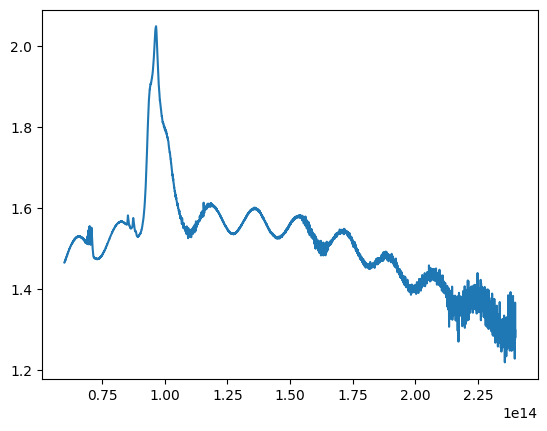

In [95]:
plt.plot(frequenz_s,data[3][:cutoff])

## Calculation for J14028 at room temperature (20deg)

In [96]:
room_smooth, room_smoothed_out = flatten(cutoff, data[11])

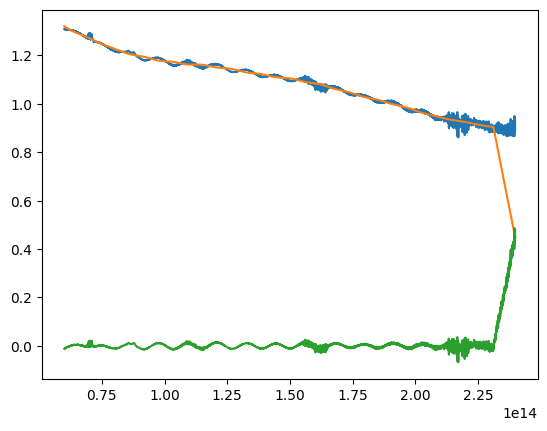

In [97]:
plt.plot(frequenz_s,data[11][:cutoff])
plt.plot(frequenz_s,room_smooth[:cutoff])
plt.plot(frequenz_s,room_smoothed_out)

In [98]:
minima_index_calc_room = scipy.signal.argrelmin(room_smoothed_out, order = 500)
minima_frequenz_room = []
minima_absorption_room = []
for minimum in minima_index_calc_room[0]:
    minima_frequenz_room.append(frequenz[minimum])
    minima_absorption_room.append(room_smoothed_out[minimum])
m_array_room = calculate_m(minima_frequenz_room)
m_array_room = m_array_room[3:]
m_array_room

[15.434447301614046,
 14.414634155886741,
 12.38379022568226,
 12.337612296752692,
 10.523980839666178,
 10.124207839998222,
 8.475682082499548,
 7.820987671247991,
 7.153153149762617]

In [99]:
m_array_room_clean = np.arange(7,16,1)[::-1]
m_array_room_clean

array([15, 14, 13, 12, 11, 10,  9,  8,  7])

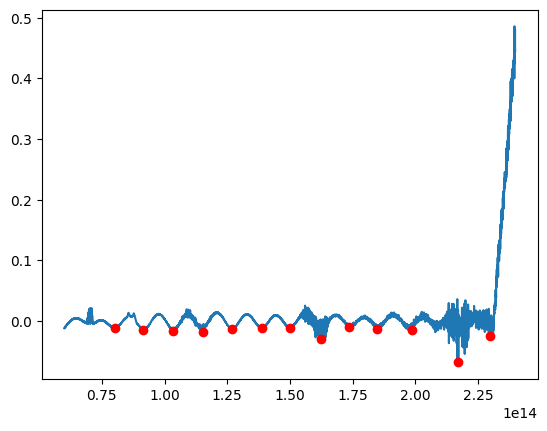

In [100]:
plt.plot(frequenz_s,room_smoothed_out)
plt.plot(minima_frequenz_room,minima_absorption_room,'ro')

### modelling the refractive index

In [101]:
def polynomial(x,a0,a1,a2,a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def refractive_index(m,L,f):
    wavelength = scipy.constants.c/f
    n = (m * wavelength) / (2 * L)
    return n 

In [102]:
n_array_room = []
for i in range(len(m_array_room_clean)):
    n_array_room.append(refractive_index(m_array_room_clean[i],4.6e-6,minima_frequenz_room[i]))
n_array_room

[2.1283946200484283,
 2.100888805909074,
 2.133621984259882,
 2.115676854674822,
 2.0650225329058847,
 2.0075284429171725,
 1.9526740324408516,
 1.876394705174132,
 1.7978552830506873]

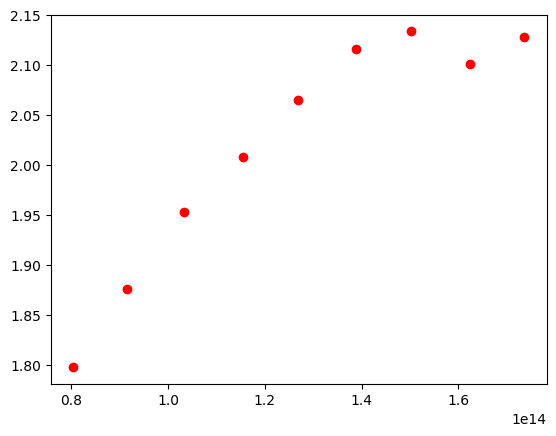

In [103]:
plt.plot(minima_frequenz_room[4:],n_array_room,'ro')

In [104]:
params_J14, cov = scipy.optimize.curve_fit(polynomial, minima_frequenz_room[4:], n_array_room)

In [105]:
params_J14

array([ 1.04325282e+00,  1.03669534e-14, -2.23384854e-30, -1.25949566e-43])

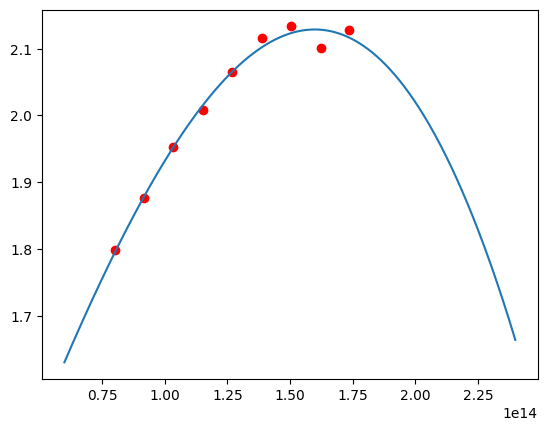

In [106]:
plt.plot(minima_frequenz_room[4:],n_array_room,'ro')
plt.plot(frequenz_s, polynomial(np.array(frequenz_s), *params_J14))

In [107]:
def optdick_total(f):
    return 4.6e-6 * polynomial(np.array(f), *params_J14)

In [108]:
params_STINS = np.array([ 7.62392205e-01,  1.95423832e-14, -9.96420756e-29,  1.83173412e-43])

In [109]:
def optdick_STINS(f): 
    return 3.5e-6 * polynomial(np.array(f), *params_STINS)

In [110]:
def optdick_toppart(f):
    return optdick_total(f) - optdick_STINS(f)

In [111]:
def dispersion_toppart(f):
    return optdick_toppart(f) / 1.1e-6

In [112]:
dispersion_toppart(frequenz_s)

array([-0.18455542, -0.18364953, -0.18274385, ...,  1.67560471,
        1.67551621,  1.67542775])

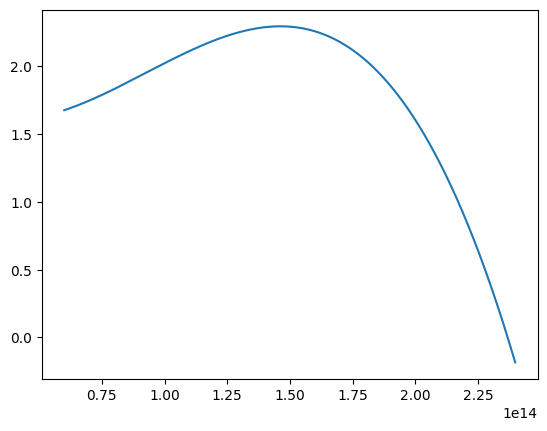

In [113]:
plt.plot(frequenz_s, dispersion_toppart(frequenz_s))

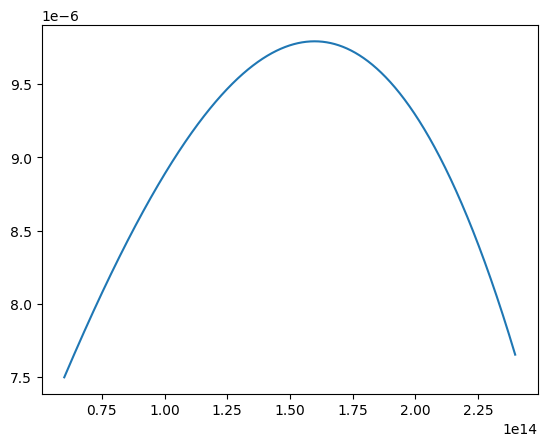

In [114]:
plt.plot(frequenz_s, optdick_total(frequenz_s))

In [115]:
n_minima = dispersion_toppart(minima_frequenz_room[4:])
n_minima

array([2.1370812 , 2.24288144, 2.29112652, 2.28504143, 2.23527748,
       2.15733781, 2.05227823, 1.9410871 , 1.83503374])

In [116]:
L_array = []
for i in range(len(n_minima)):
    L_array.append(länge(m_array_room_clean[i],n_minima[i],minima_frequenz_room[i]))

In [117]:
L_array

[4.581302400374841e-06,
 4.308782592869913e-06,
 4.2837709089755595e-06,
 4.259053427246701e-06,
 4.249630640824751e-06,
 4.280567838923283e-06,
 4.376746002604586e-06,
 4.446691558882956e-06,
 4.506802312627106e-06]

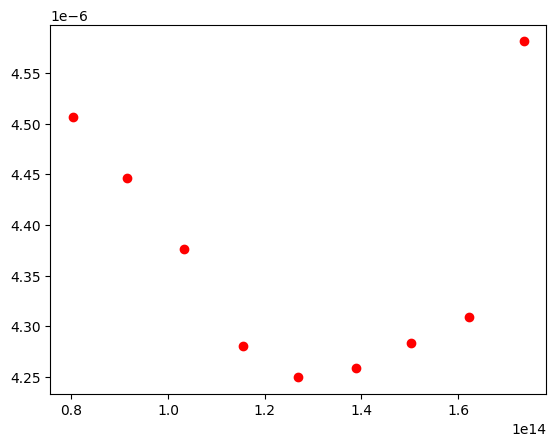

In [118]:
plt.plot(minima_frequenz_room[4:],L_array,'ro')